In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community

COLORS = ['magenta', 'darkviolet', 'blue', 'deepskyblue', 'darkcyan', 'lime', 'gold',
          'orange', 'sienna', 'red', 'silver']

In [2]:
def search_circle(circles_dict, nodeID):
    for key, values in circles_dict.items():
        if nodeID in values:
            return key
    return 'None'

def make_table(G, nodes, feature_names, label):
    column_names = []
    for feature in feature_names:
        column_names.append(feature + '-' + label)
    table = pd.DataFrame(data=None, columns=column_names, index=nodes)
    for index, row in table.iterrows():
        for column in column_names:
            feature = column.split('-')
            feature = feature[0]
            try: 
                table.loc[index, column] = G.node[index][feature]
            except KeyError: # node does not exist in the graph 
                pass
    table = table.reset_index()
    table = table.rename(columns={"index": "NodeID"})
    if label == 'ALL_NODES':
        table.style.apply(highlight, axis=1)
    name = 'attributes_table_' + label
    table.to_csv(name + '.csv', index = False)
    return table

def highlight(s):
    circle = search_circle(circles414_dict, s.NodeID)
    if circle != 'None':
        circle_number = int(circle[-1])
        c = COLORS[circle_number]
        return ['background-color: ' + COLORS[circle_number]]*13
    elif s.NodeID == ego_node:
        return ['background-color: yellow']*13
    else:
        return ['background-color: white']*13

#### Processing Ego Node 414 and Adding Its Attributes

In [3]:
# NodeID 414 (not in here) and its ego network
G414 = nx.Graph()
edges414 = np.genfromtxt("facebook/facebook/414.edges", dtype=str, delimiter=' ')

for edge in edges414:
    G414.add_edge(edge[0], edge[1])
    
# add the ego node to its own ego network
G414.add_node('414')

ego414features_values = np.genfromtxt("facebook/facebook/414.egofeat", dtype=str, delimiter=' ')
ego414featnames = np.genfromtxt("facebook/facebook/414.featnames", dtype=str, delimiter=' ')

# add attributes to the ego node 414 and set the feature names for other nodes to get later
dimension = 0
feature_names = []
last_attribute_value = ''
last_feature_name = ''
for feature in ego414featnames:
    if ego414features_values[dimension] == '1':
        if feature[1] not in feature_names:
            attribute = {'414': {feature[1]: feature[3]}}
            nx.set_node_attributes(G414, attribute)
            feature_names.append(feature[1])
            last_attribute_value = feature[3]
            last_feature_name = feature[1]
        elif feature[1] == last_feature_name:
            attribute = {'414': {feature[1]: last_attribute_value + '-' + feature[3]}}
            nx.set_node_attributes(G414, attribute)
            last_attribute_value = last_attribute_value + '-' + feature[3]
    dimension += 1 
    
# add attributes to the rest of the nodes in this ego network (based on features of ego node)
file = open('facebook/facebook/414.feat', 'r') 
lines = file.readlines() 
for line in lines: 
    temp = line.split()
    nodefeatures_values = temp[1:]
    dimension = 0
    last_attribute_value = ''
    last_feature_name = ''
    for feature in ego414featnames:
        if nodefeatures_values[dimension] == '1':
            if feature[1] in feature_names:
                if last_attribute_value == '':
                    attribute = {temp[0]: {feature[1]: feature[3]}}
                    nx.set_node_attributes(G414, attribute)
                    last_attribute_value = feature[3]
                    last_feature_name = feature[1]
                elif feature[1] == last_feature_name:
                    attribute = {temp[0]: {feature[1]: last_attribute_value + '-' + feature[3]}}
                    nx.set_node_attributes(G414, attribute)
                    last_attribute_value = last_attribute_value + '-' + feature[3]
                else:
                    last_attribute_value = ''
                    last_feature_name = ''
            else:                  
                last_attribute_value = ''
                last_feature_name = ''
        dimension += 1 
        
# add NA to feature values that were unavailable
for node in G414.nodes:
    for feature in feature_names:
        try:
            value = G414.node[node][feature]
        except KeyError:
            attribute = {node: {feature: ' '}}
            nx.set_node_attributes(G414, attribute)

In [0]:
circles414_dict = {}
file = open('facebook/facebook/414.circles', 'r') 
lines = file.readlines() 
for line in lines: 
    temp = line.split()
    circles414_dict.update({temp[0]: temp[1:]})

#### Make and save table of Attributes

In [0]:
ego_node = '414'
top_pr_nodes = ['376', '592', '428']
top_bc_nodes = ['436', '635', '422']
top_cc_nodes = ['373', '553', '436']
top_dc_nodes = ['376', '373', '513']
top_ebc_nodes = ['436', '647', '373']

g414 = sorted(G414.nodes, key=str)

all_tables = []
all_tables.append(make_table(G414, g414, feature_names, 'ALL_NODES'))
all_tables.append(make_table(G414, top_pr_nodes, feature_names, 'TOP_PR'))
all_tables.append(make_table(G414, top_bc_nodes, feature_names, 'TOP_BC'))
all_tables.append(make_table(G414, top_cc_nodes, feature_names, 'TOP_CC'))
all_tables.append(make_table(G414, top_ebc_nodes, feature_names, 'TOP_EBC'))

for circle, circle_nodes in circles414_dict.items():
    all_tables.append(make_table(G414, circle_nodes, feature_names, circle))

In [0]:
ego_node = '414'
TOP_PR_NODES = ['376', '592', '428']
TOP_BC_NODES = ['436', '635', '422']
TOP_CC_NODES = ['373', '553', '436']
TOP_DC_NODES = ['376', '373', '513']
TOP_EBC_NODES = ['436', '647', '373']

g414 = sorted(G414.nodes, key=str)

ColorLegend = {'top_pr_nodes': 'red','top_bc_nodes': 'green',
               'top_cc_nodes': 'blue', 'top_dc_nodes': 'gold','top_ebc_nodes':'violet','mixed':'orange'}
pos = nx.spring_layout(G414)

# f = plt.figure(1)
# ax = f.add_subplot(1,1,1)
# for label in ColorLegend:
#     ax.plot([0],[0], color=ColorLegend[label], label=label)

color_map = []
for node in G414:
    if node in TOP_PR_NODES and node in TOP_BC_NODES and node in TOP_CC_NODES and node in TOP_DC_NODES and node in TOP_EBC_NODES:
        color_map.append(ColorLegend['mixed'])
    elif node in nodes_education_type and node in nodes_hometown_id:
        color_map.append(ColorLegend['mixed'])   
    elif node in nodes_location_id and node in nodes_hometown_id:
        color_map.append(ColorLegend['mixed']) 
    elif node in nodes_education_type and node in nodes_location_id:
        color_map.append(ColorLegend['mixed']) 
    elif node in TOP_PR_NODES:
        color_map.append(ColorLegend['top_pr_nodes']) 
    elif node in TOP_BC_NODES:
        color_map.append(ColorLegend['top_bc_nodes'])
    elif node in TOP_CC_NODES:
        color_map.append(ColorLegend['top_cc_nodes'])
    elif node in TOP_DC_NODES:
        color_map.append(ColorLegend['top_dc_nodes']) 
    elif node in TOP_EBC_NODES:
        color_map.append(ColorLegend['top_ebc_nodes'])    
    else:
        color_map.append(COLORS[-1])
        
plt.figure(figsize=(100, 60))
nx.draw_networkx(G414, pos=pos, node_color=color_map, with_labels=False, node_size=200)
plt.axis('off')
plt.savefig("node414_centrality_network.png", format="PNG")
plt.show()


In [0]:
all_tables[0].style.apply(highlight, axis=1)

In [0]:
# most popular attribute values
nodes_education_type = [x for x,y in G414.nodes(data=True) if y['education;type;anonymized']=='54-55']
nodes_hometown_id = [x for x,y in G414.nodes(data=True) if y['hometown;id;anonymized']=='84']
nodes_location_id = [x for x,y in G414.nodes(data=True) if y['location;id;anonymized']=='128']

# node 414 attribute values
node414_education_type = [x for x,y in G414.nodes(data=True) if y['education;type;anonymized']=='53-54-55']
node414_hometown_id = [x for x,y in G414.nodes(data=True) if y['hometown;id;anonymized']=='84']
node414_location_id = [x for x,y in G414.nodes(data=True) if y['location;id;anonymized']=='129']


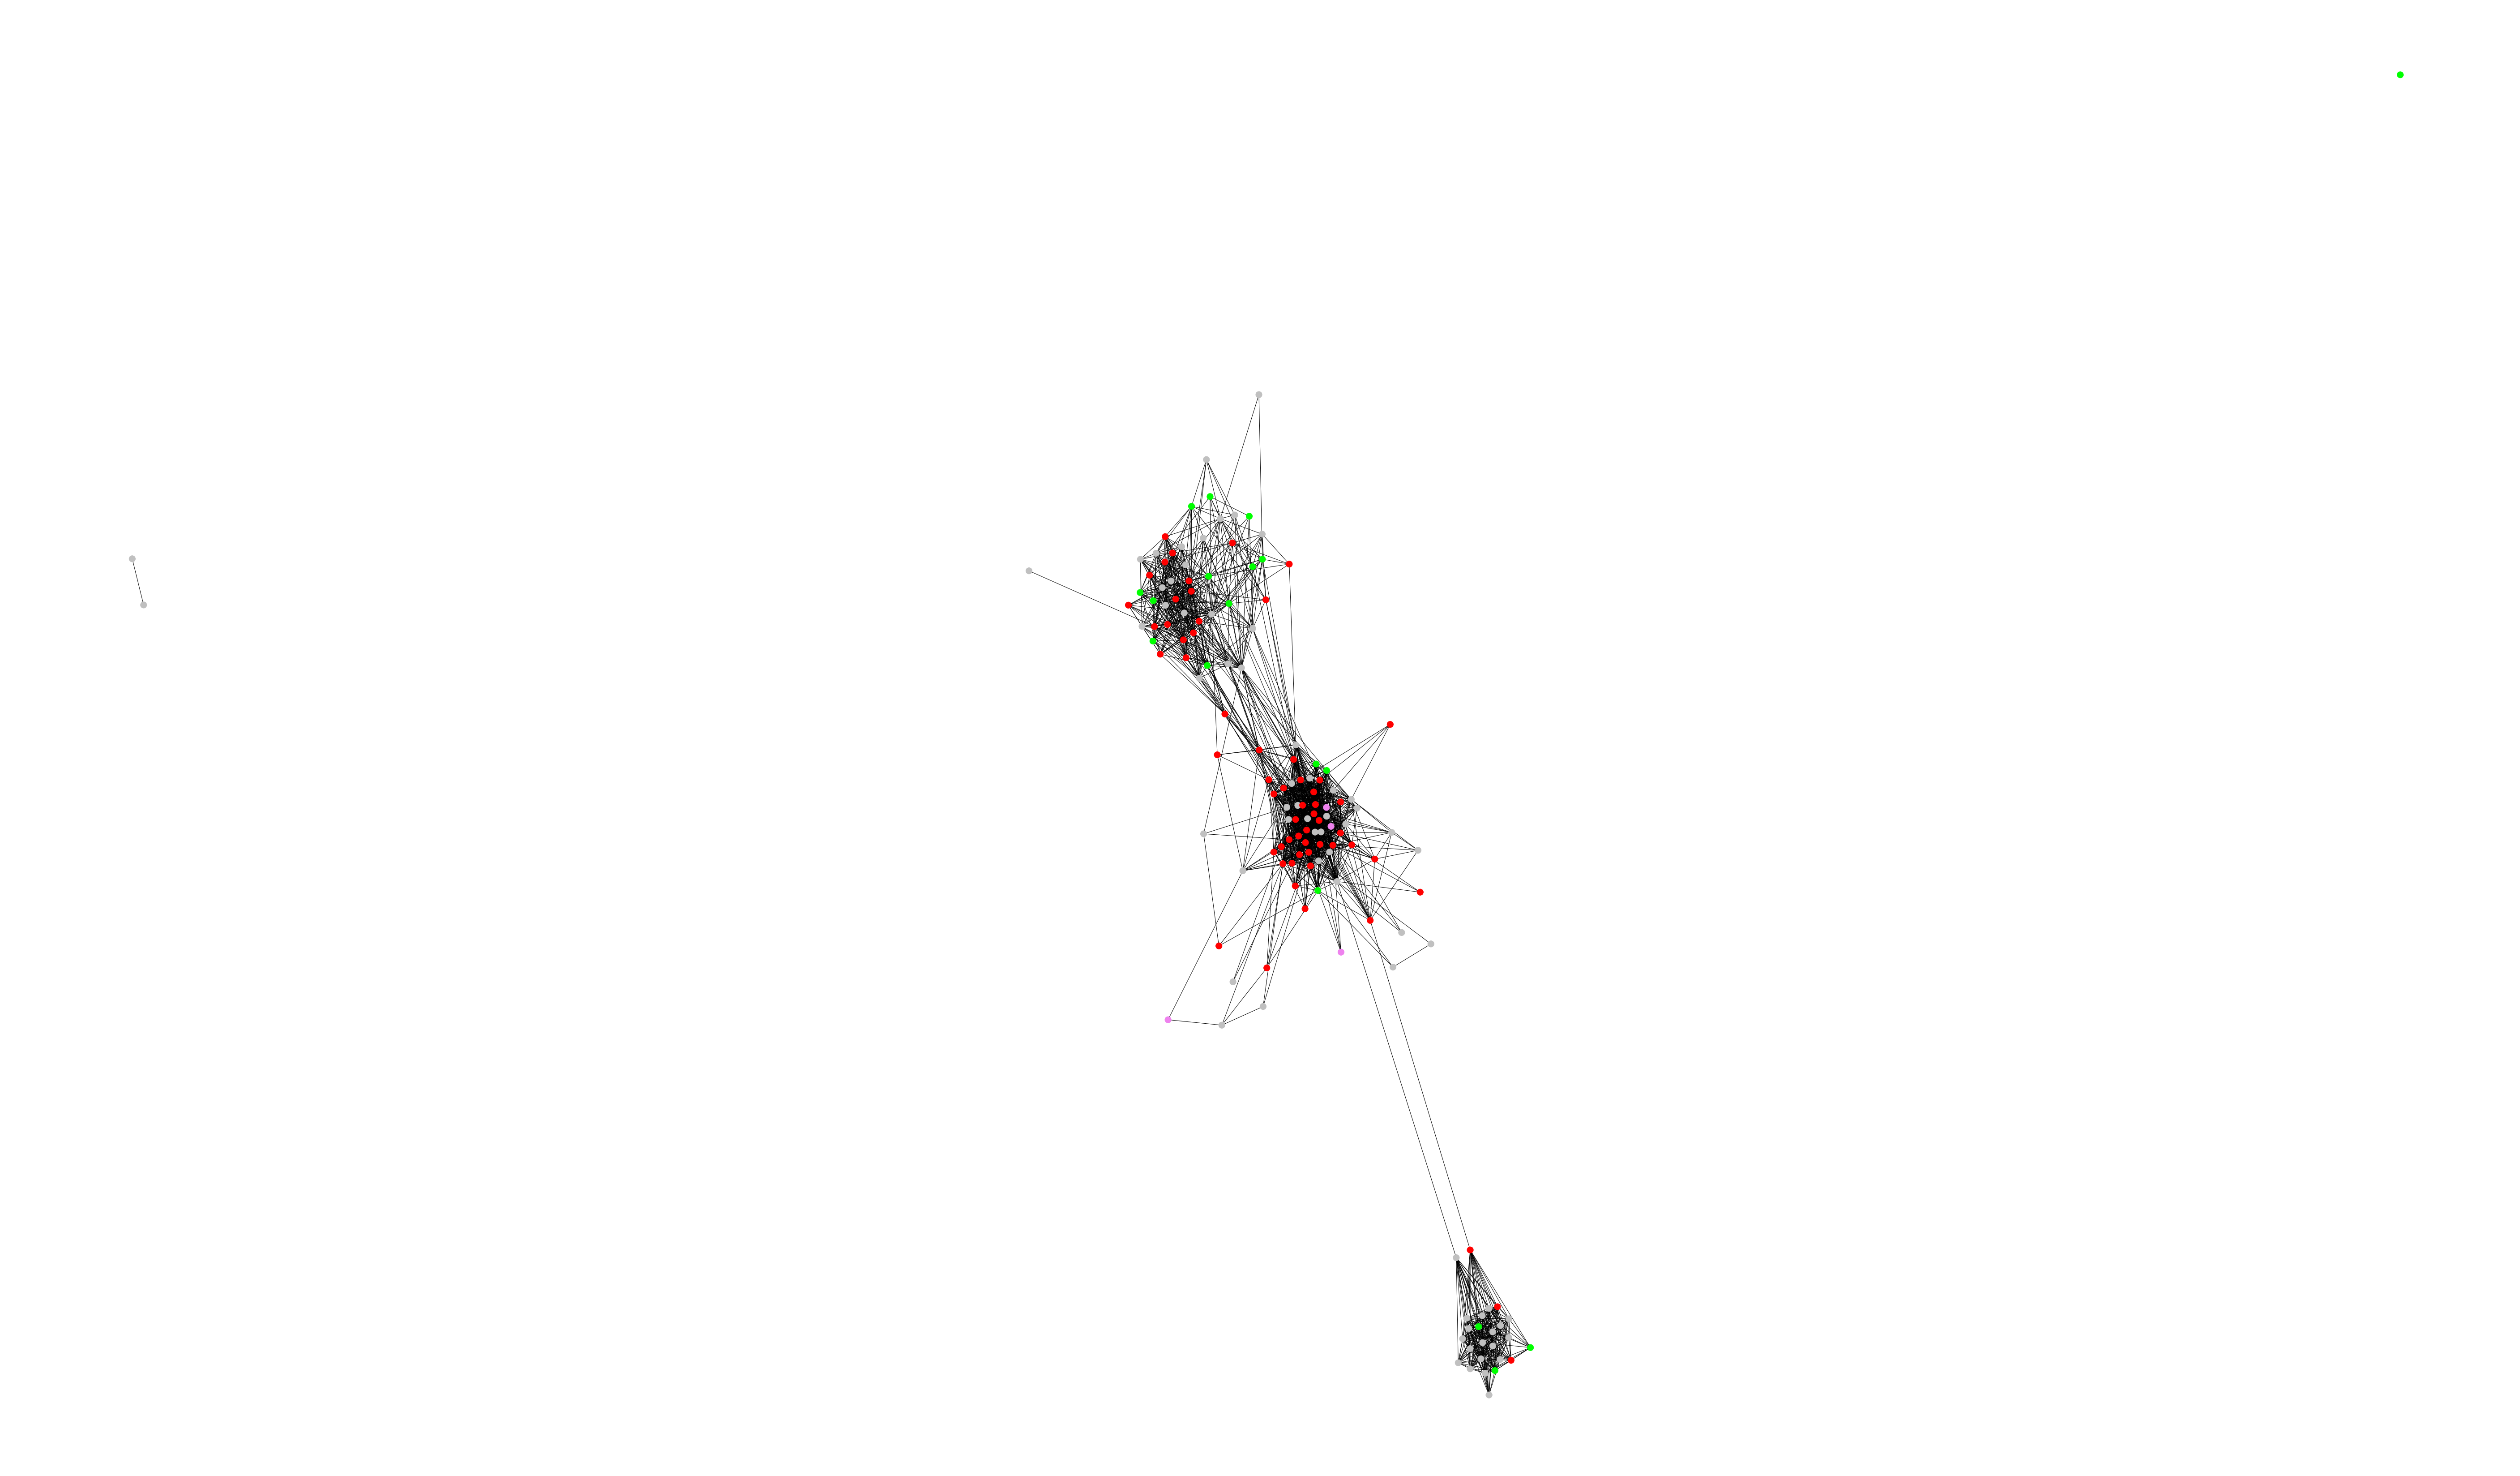

In [0]:
ColorLegend = {'education_type': 'red','hometown_id': 'lime',
               'location_id': 'violet', 'mixed': 'gold'}

# f = plt.figure(1)
# ax = f.add_subplot(1,1,1)
# for label in ColorLegend:
#     ax.plot([0],[0], color=ColorLegend[label], label=label)

color_map = []
for node in G414:
    if node in nodes_education_type and node in nodes_hometown_id and node in nodes_location_id:
        color_map.append(ColorLegend['mixed'])
    elif node in nodes_education_type and node in nodes_hometown_id:
        color_map.append(ColorLegend['mixed'])   
    elif node in nodes_location_id and node in nodes_hometown_id:
        color_map.append(ColorLegend['mixed']) 
    elif node in nodes_education_type and node in nodes_location_id:
        color_map.append(ColorLegend['mixed']) 
    elif node in nodes_education_type:
        color_map.append(ColorLegend['education_type']) 
    elif node in nodes_hometown_id:
        color_map.append(ColorLegend['hometown_id'])
    elif node in nodes_location_id:
        color_map.append(ColorLegend['location_id'])
    else:
        color_map.append(COLORS[-1])
        
plt.figure(figsize=(100, 60))
nx.draw_networkx(G414, node_color=color_map, with_labels=False, node_size=200)
plt.axis('off')
plt.savefig("most_popular_mutual_attributes_network.png", format="PNG")
plt.show()


In [0]:
color_map2 = []
for node in G414:
    if node in node414_education_type and node in node414_hometown_id and node in node414_location_id:
        color_map2.append(ColorLegend['mixed'])
    elif node in node414_education_type and node in node414_hometown_id:
        color_map2.append(ColorLegend['mixed'])   
    elif node in node414_location_id and node in node414_hometown_id:
        color_map2.append(ColorLegend['mixed']) 
    elif node in node414_education_type and node in node414_location_id:
        color_map2.append(ColorLegend['mixed']) 
    elif node in node414_education_type:
        color_map2.append(ColorLegend['education_type']) 
    elif node in node414_hometown_id:
        color_map2.append(ColorLegend['hometown_id'])
    elif node in node414_location_id:
        color_map2.append(ColorLegend['location_id'])
    else:
        color_map2.append(COLORS[-1])
        
plt.figure(figsize=(100, 60))
nx.draw_networkx(G414, node_color=color_map2, with_labels=False, node_size=200)
plt.axis('off')
plt.savefig("node414_mutual_attributes_network.png", format="PNG")
plt.show()

##### Link Prediction
https://towardsdatascience.com/learning-in-graphs-with-python-part-3-8d5513eef62d

In [1]:
import random
from sklearn.metrics import roc_curve, auc, roc_auc_score

n = G414.number_of_nodes()
m = G414.number_of_edges()
print("Number of nodes :", str(n))
print("Number of edges :", str(m))
print("Number of connected components :", str(nx.number_connected_components(G414)))

NameError: ignored

In [0]:
# Take a random sample of edges
edge_subset = random.sample(G414.edges(), int(0.25 * G414.number_of_edges()))

# Remove some edges
G414_sample = G414.copy()
G414_sample.remove_edges_from(edge_subset)

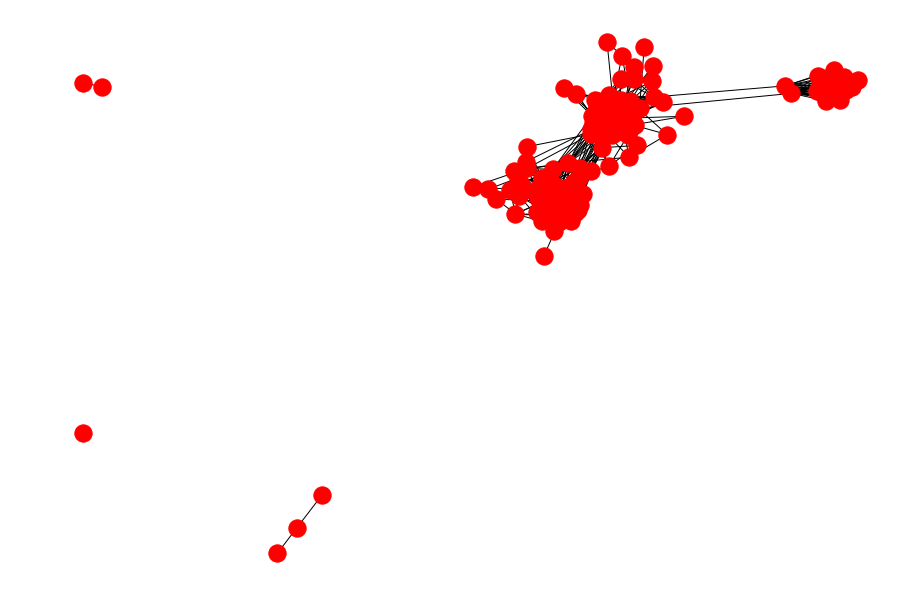

In [0]:
plt.figure(figsize=(12,8))
nx.draw(G414_sample)

In [0]:
edge_subset_size = len(list(edge_subset))
print("Deleted : ", str(edge_subset_size))
print("Remaining : ", str((m - edge_subset_size)))

Deleted :  423
Remaining :  1270


In [0]:
prediction_jaccard = list(nx.jaccard_coefficient(G414_sample))

score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_jaccard])

In [0]:
prediction_adamic = list(nx.adamic_adar_index(G414_sample))

score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_adamic])

In [0]:
prediction_pref = list(nx.preferential_attachment(G414_sample))

score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_pref])

In [0]:
# Compute the ROC AUC Score

fpr_jaccard, tpr_jaccard, _ = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)

fpr_pref, tpr_pref, _ = roc_curve(label_pref, score_pref)
auc_pref = roc_auc_score(label_pref, score_pref)

fpr_adamic, tpr_adamic, _ = roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)

In [0]:
fpr = [fpr_jaccard, fpr_pref, fpr_adamic]
tpr = [tpr_jaccard, tpr_pref, tpr_adamic]
auc = [auc_jaccard, auc_pref, auc_adamic]

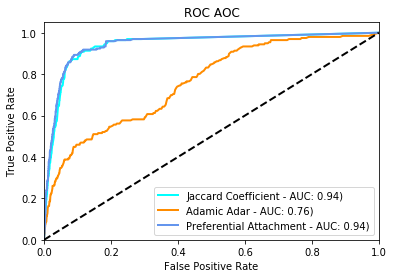

In [0]:
import matplotlib.pyplot as plt
from itertools import cycle

lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

labels = ['Jaccard Coefficient - AUC: %0.2f)' % auc[0],
          'Adamic Adar - AUC: %0.2f)' % auc[1],
          'Preferential Attachment - AUC: %0.2f)' % auc[2]]

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=labels[i])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AOC')
plt.legend(loc="lower right")
plt.show()

Node Labeling via Labels Propagation Algorithm (LPA)

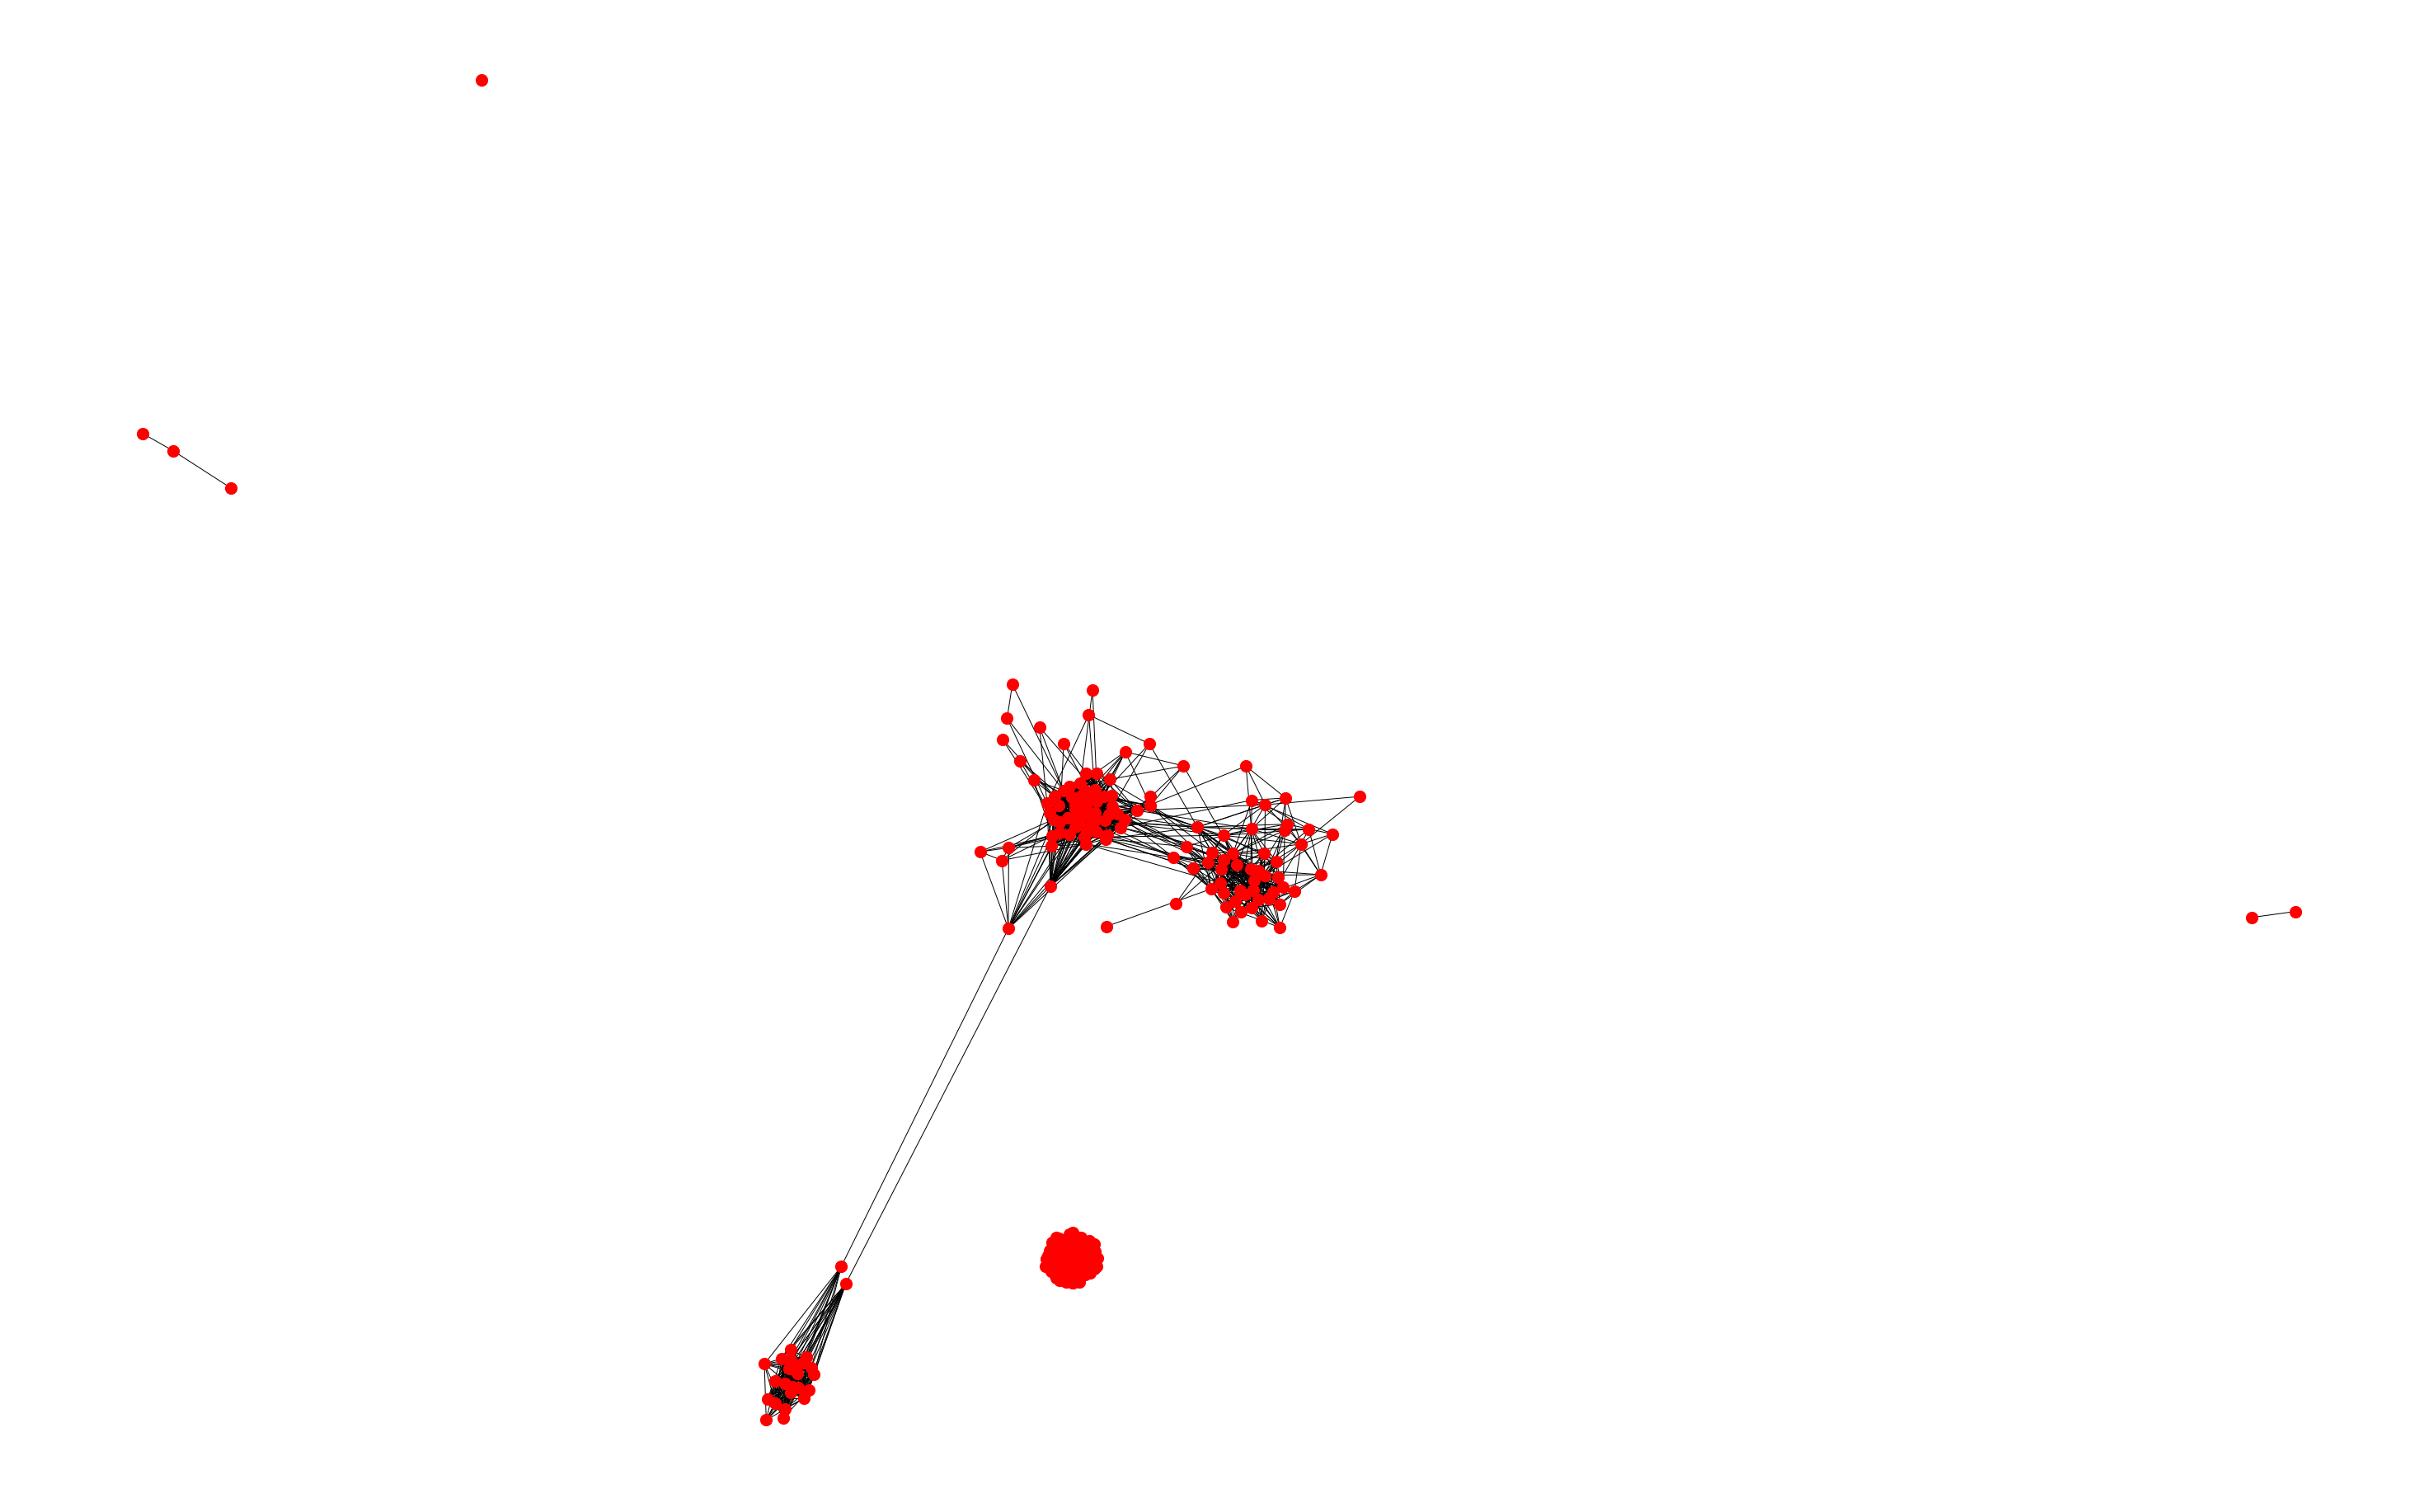

In [0]:
jaccard_edges = []
for i, tup in zip(range(len(prediction_jaccard)), prediction_jaccard):
    jaccard_edges.append((tup[0], tup[1]))
    
jaccard_g414 = G414_sample.copy()
jaccard_g414.add_edges_from(jaccard_edges)
plt.figure(figsize=(40,25))
nx.draw(jaccard_g414, node_size=200)

plt.savefig("node414_relinked_jaccard.png", format="PNG")

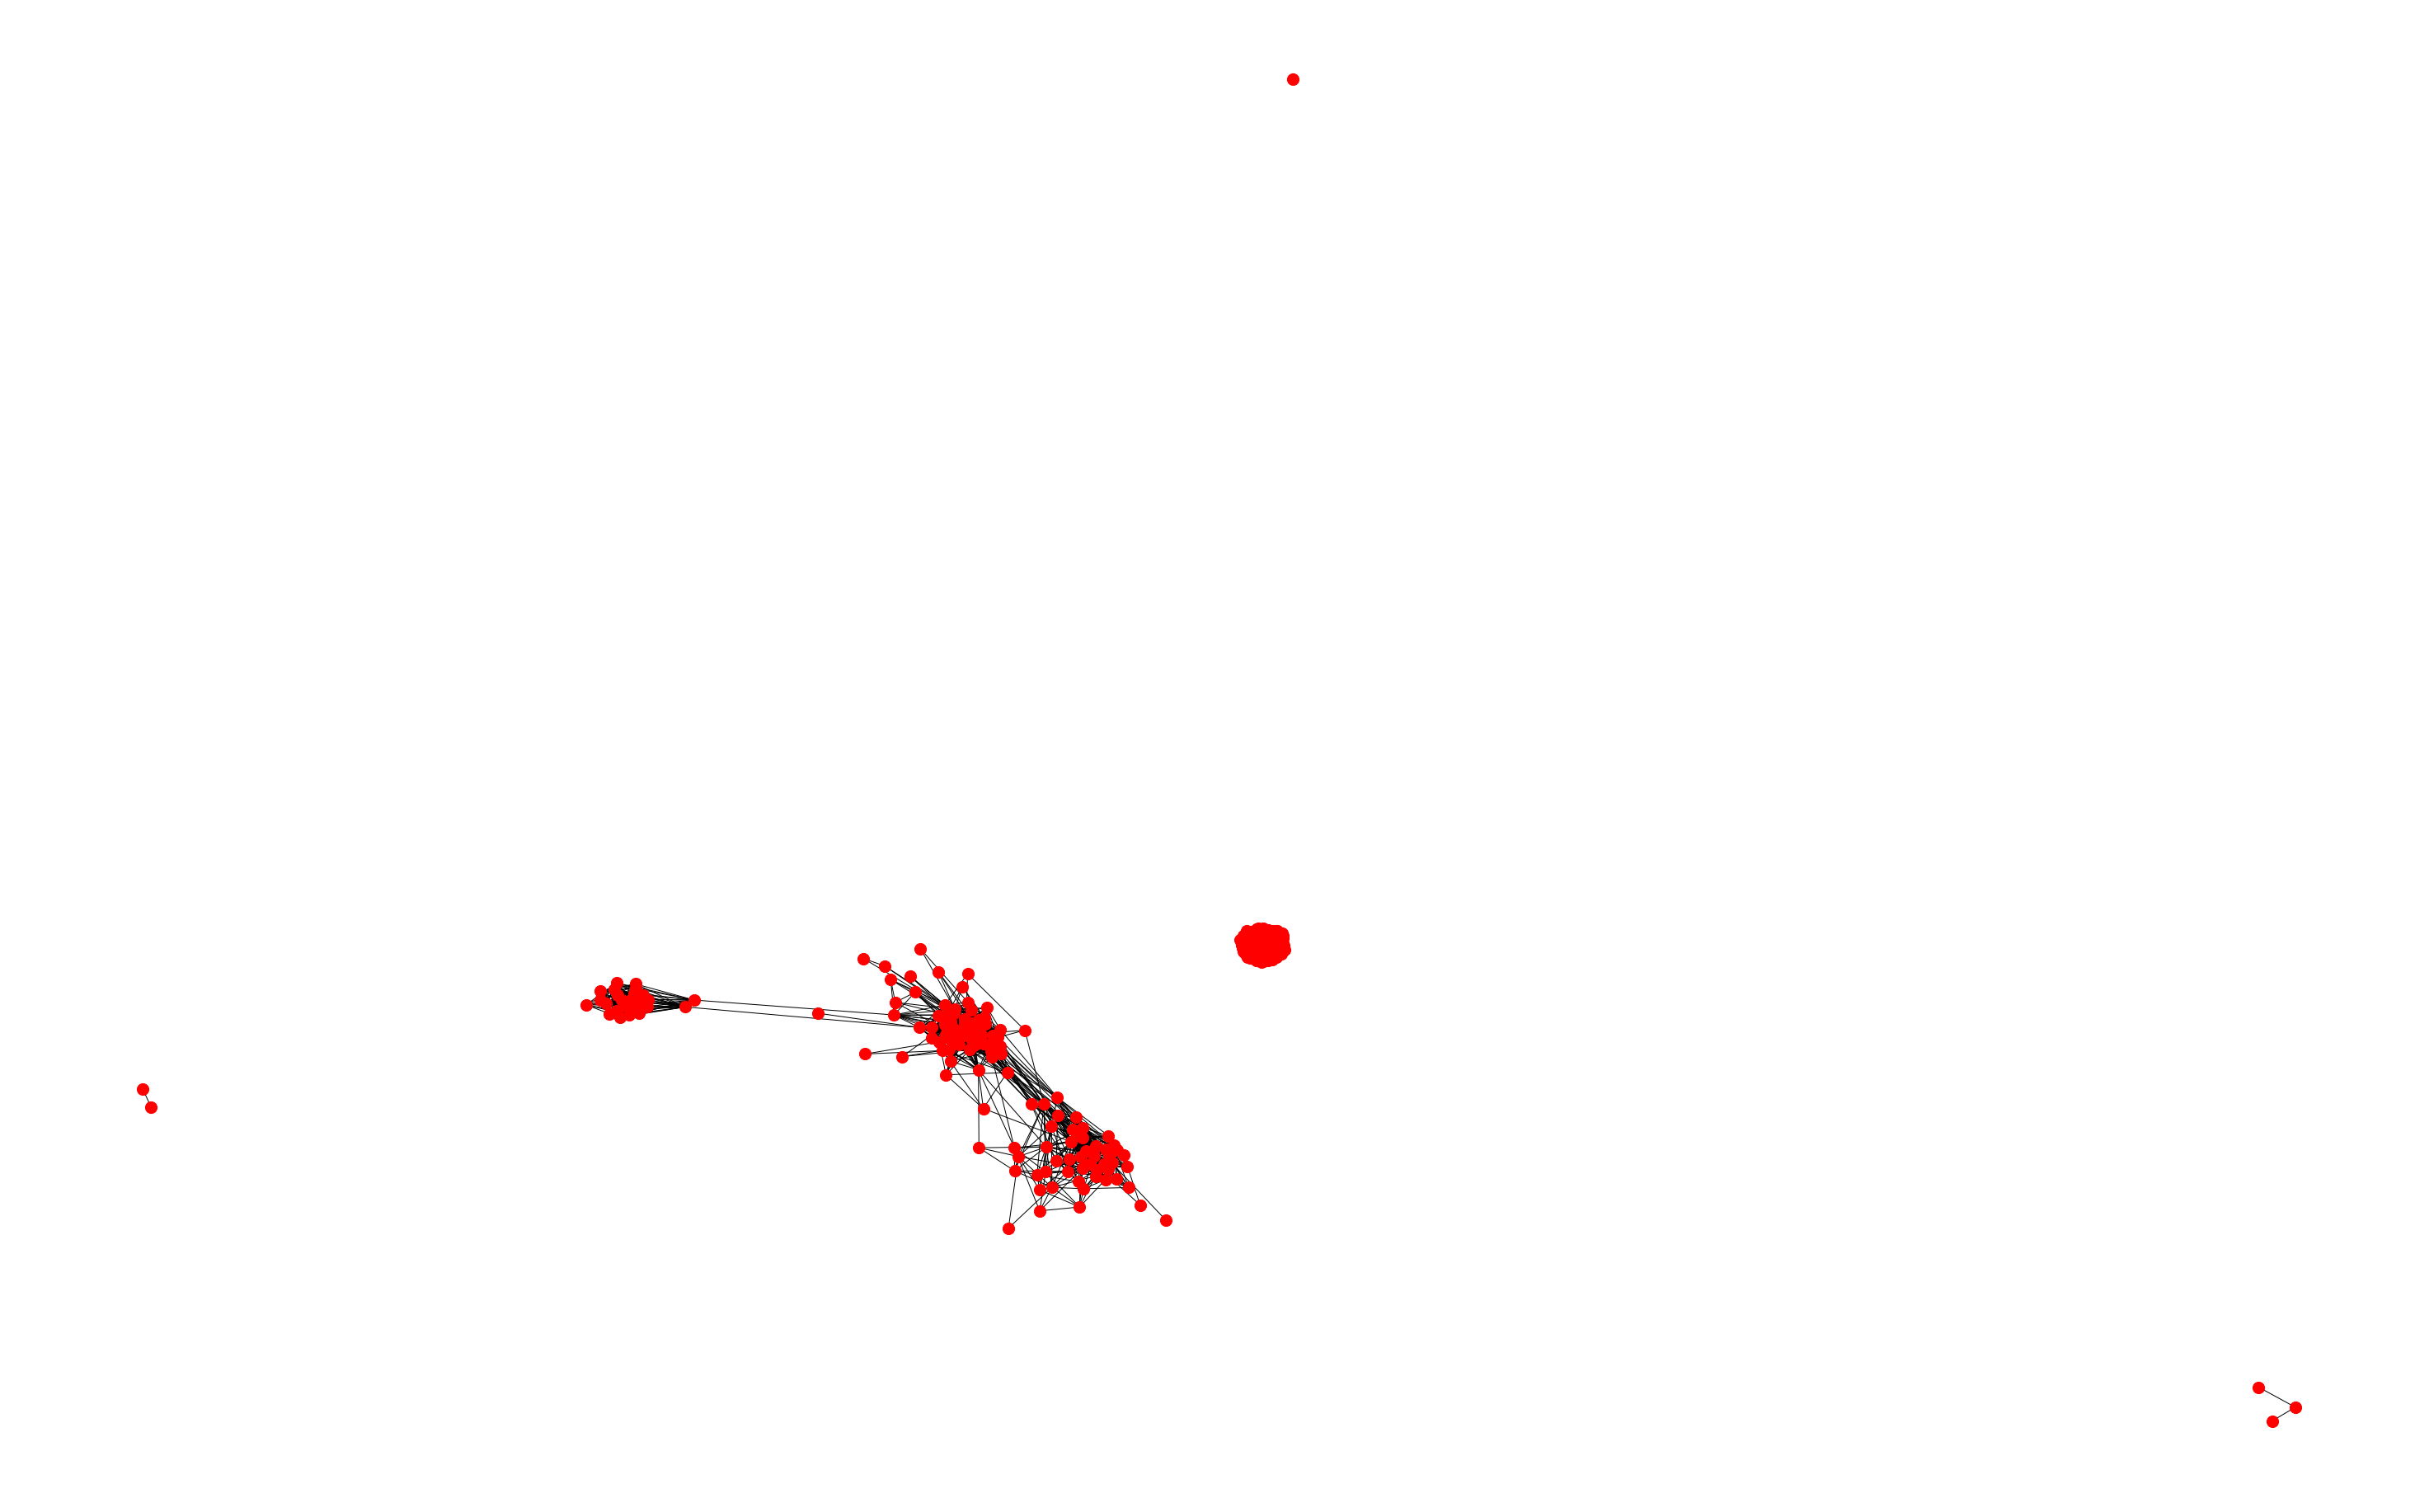

In [0]:
adamic_edges = []
for i, tup in zip(range(len(prediction_adamic)), prediction_adamic):
    adamic_edges.append((tup[0], tup[1]))

adamic_g414 = G414_sample.copy()
adamic_g414.add_edges_from(adamic_edges)
plt.figure(figsize=(40, 25))
nx.draw(adamic_g414, node_size=200)

plt.savefig("node414_relinked_adamic.png", format="PNG")

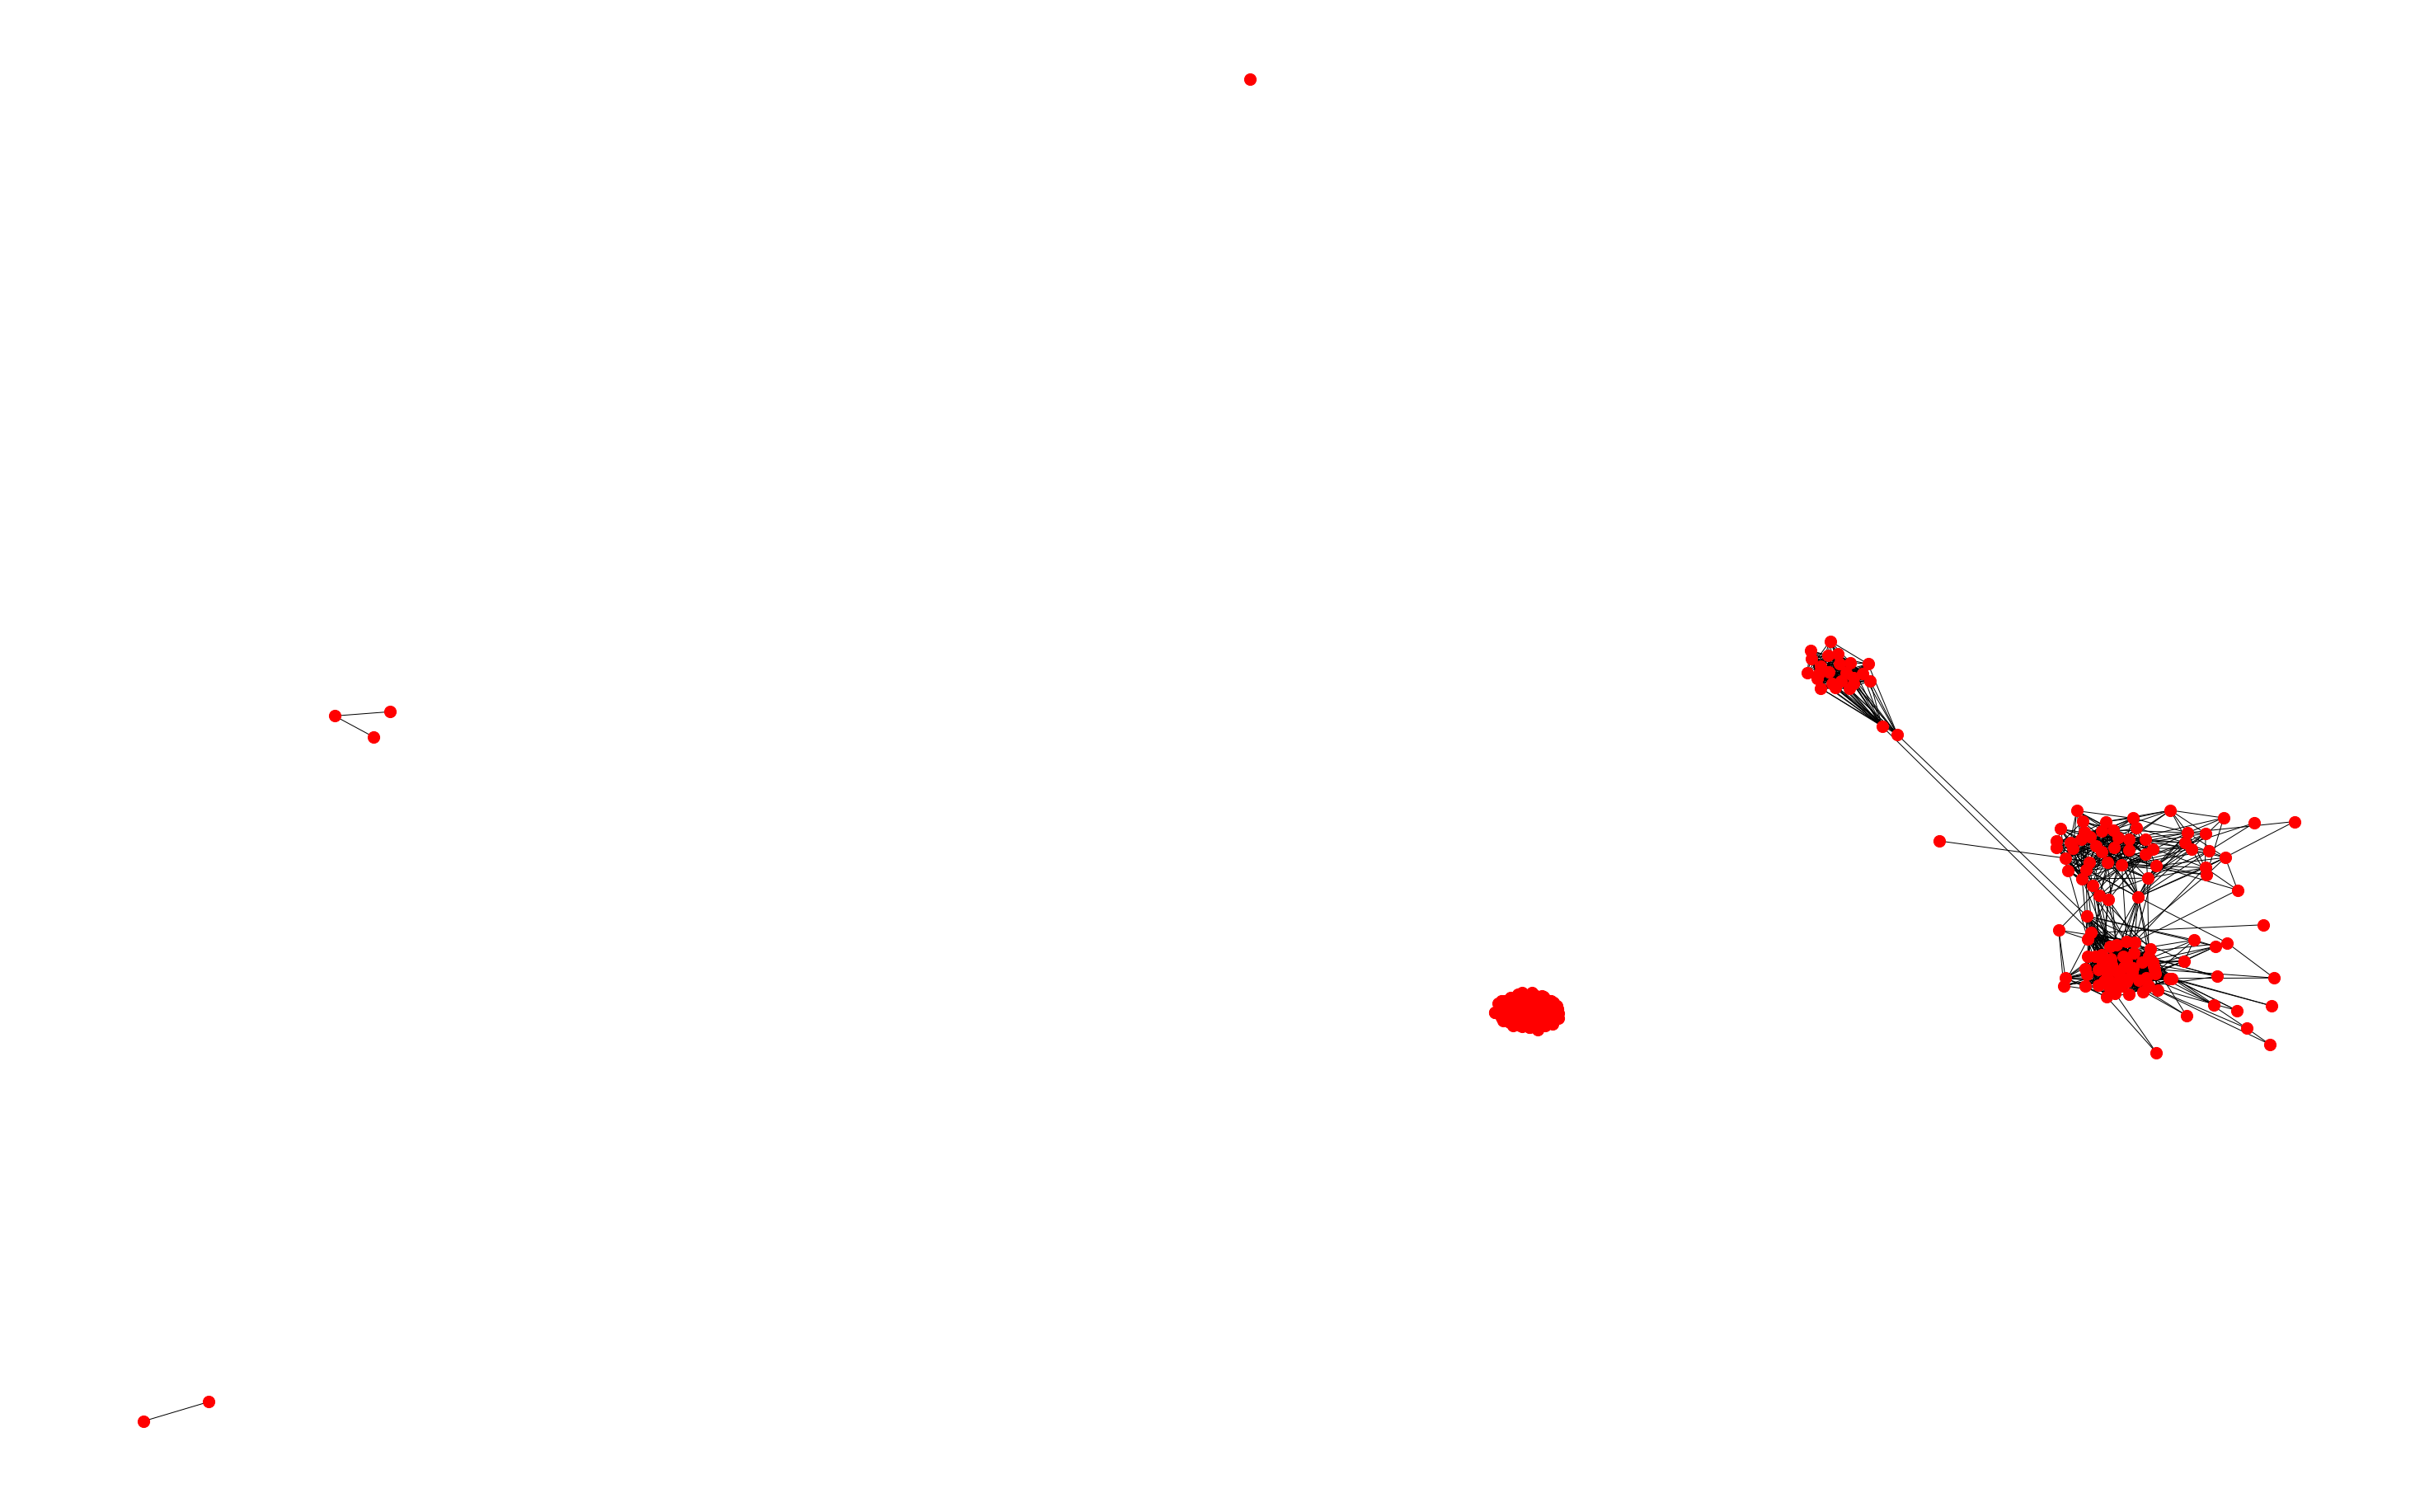

In [0]:
pref_edges = []
for i, tup in zip(range(len(prediction_pref)), prediction_pref):
     pref_edges.append((tup[0], tup[1]))

pref_g414 = G414_sample.copy()
pref_g414.add_edges_from(pref_edges)
plt.figure(figsize=(40, 25))
nx.draw(pref_g414, node_size=200)

plt.savefig("node414_relinked_pref.png", format="PNG")